# 채점기준

1. 데이터 전처리 및 가정 (assumptions) 만족 여부 확인

2. logistic regression 수행 및 적절한 cutoff 결정

3. 연구 목적에 맞게 다양한 성능 지표의 해석

4. 결과해석 - 변수해석, odds ratio (승산비) 해석

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


필요한 Python Library들을 importing 해주자.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#Step0. Introduction of datasets & Assumptions for Logistic Regression

> ## Introduction of datasets

[데이터 출처](https://www.kaggle.com/datasets/vivovinco/nba-player-stats)

- 참고 : 본 데이터셋은 2022 spring DM 4주차 PCA, FA 실습 부분에서 이미 사용했던 데이터셋입니다.

본 데이터는 [미국 NBA농구 선수들의 2021-2022시즌 동안의 기록에 대한 평균치 데이터](https://www.basketball-reference.com/leagues/NBA_2022_per_game.html)로 데이터셋은 non-null의 총 30개의 변수들과 784개의 관측치(행: 각 선수의 시즌평균기록)로 구성되어 있다.

다음은 데이터셋에 등장하는 각 변수에 대한 소개이다.
- `Rk` : Rank
- `Player` : Player's name
- `Pos` : Position
- `Age` : Player's age
- `Tm`  : Team 
- `G`   : Games Played
- `Gs`  : Games Started
- `MP`  : Minutes played per game
- `FG`  : Field Goals per game
- `FGA` : Field Goal attempts per game
- `FG%` : Field goal percentage
- `3P`  : 3-point field goals per game
- `3PA` : 3-point field goal attempts per game
- `3P%` : 3-point field goal percentage
- `2P`  : 2-point field goals per game
- `2PA` : 2-point field goal attempts per game
- `2P%` : 2-point field goal percentage
- `eFG%`: Effective field goal percentage
- `FT`  : Free Throws per game
- `FTA` : Free throw attempts per game
- `FT%` : Free throw percentage
- `ORB` : Offensive rebounds per game
- `DRB` : Defensive rebounds per game
- `TRB` : Total rebounds per game
- `AST` : Assists per game
- `STL` : Steals per game
- `BLK` : Blocks per game
- `TOV` : Turnovers per game
- `PF`  : Personal fouls per game
- `PTS` : Points per game

## Assumptions for Logistic Regression

### A. Binomial Logistic Regression을 사용하는 이유

**타겟 변수 : `Pos` (Position)**
  
  1. Binary Target을 modeling 하는 경우

  - 농구선수의 포지션 예측
    - 기존 농구선수 포지션은 경기 중 포지션 기준으로 5명이 각각 하나씩 맡게 됨

    - 이를 **2개의 nominal target**
      - 골대를 기준으로 비교적 멀리서 플레이하는 가드(1)와
      - 가드에 해당하지 않는 나머지(0; 포워드와 센터)로 설정함.


  2. 예측 확률을 알고 싶은 경우


  3. **해석 가능한 모델**을 얻고자 하는 경우
    - 어떠한 설명변수(요인)가 연구 관심 분야에 영향을 미치는 지 파악해볼 수 있다.
    - 인공신경망을 활용하는 기법에 비해 학습 모델의 성능은 떨어질 수 있으나 설명이 용이하다는 장점이 있다.


  4. 클래스를 선형으로 분리 가능한 경우 [[참고]](https://keepmind.net/%ea%b8%b0%ea%b3%84%ed%95%99%ec%8a%b5-linear-model-2/)
    - 데이터가 선형분리가 가능한 경우에 Logistic Regression을 사용가능하다.
    - 앞선 HW3에서 PCA 및 FA를 진행하였고, 선형으로 모델링 됨을 확인한 바 있다.


### B. Logistic Regression을 진행하기 위한 필수 가정들
#####1. 관측치들 간 독립성: 데이터의 샘플들은 랜덤하게 얻어져야 함. (반복적 측정 X, 시간 및 공간에 따른 상관관계 X)
  - 본 실습에서 활용하는 2021/2022 NBA 농구선수의 시즌 평균기록 데이터의 경우
  개별 선수기록으로 구성되므로 관측치들 간의 독립성이 확보된다.

#####2. 잔차 간 등분산성 ( = 오차 간 등분산성)
  - 의미 : 회귀 모형에 포함된 잔차(오차)의 분산값이 설명변수의 값과 관계없이 일정함.

  - 통계적 검정 방법 [[참고1]](https://zephyrus1111.tistory.com/57)
    - Brown-Forsythe 검정
        - 선형모형을 적합
        - 적합한 선형모형(fitted model)의 잔차를 구함.
        - 적합에 사용한 설명변수를 이용하여 잔차를 두 그룹으로 나눔.
        - 각 그룹에서 잔차의 중앙값을 구하고, 잔차와 중앙값 사이의 평균을 구함.
        - 두 그룹에서 계산한 차이를 이용하여 Two Sample t-test를 진행
    - Breusch-Pagan 검정 :
      (가정)
      - 샘플 수가 많아야함.
      - 오차항이 독립이고 정규분포를 따라야 함.
      - 오차의 분산이 설명변수와 연관이 있어야 함.

  - 시각화로 잔차와 설명변수의 선형성을 살펴보는 방법 [[참고2]](https://mindscale.kr/course/basic-stat-python/14/)

  - 본 실습에서는 시각화로 선형성을 살펴보았다.


3. 독립 변수와 log odds 간의 linearity
  - python에서는 그래프를 통해 선형성을 판단해보아야 한다.
4. 이상치가 존재하지 않아야 함
  - 실력이 뛰어난 농구선수의 경우 필연적으로 outlier data가 발생할 여지가 있다.
  - 이들의 outlier을 어떻게 handling 할 지에 따라 모델의 성능이 달라질 수 있을 것이다.

- 추가적으로, 적당한 수의 샘플이 존재해야 함.
  - 너무 적은 수의 데이터로 모델링 하는 것을 방지하기 위해 Target 값의 개수를 맞출 때 Oversampling을 사용

- independent variables가 너무 많을 경우 일반화 성능이 감소할 수 있음.
    - VIF를 사용하여 VIF > 10 인 설명변수의 경우 모델에서 제외함.

### Binomial Logistic Regression
- predicted response variable은 0과 1 사이의 확률 값
  - 이 때 sigmoid function을 사용하면 실수 값을 0과 1 사이의 확률 값으로 표현됨

> - 다중 로지스틱 회귀모형의 일반적 형태
  - $\log(\frac{π(x)}{1-π(x)})=α+β_1x_1+\cdots+\beta_kx_k$
  - where $π(x)=P(Y=1|x), x=(x_1, \cdots, x_k)$
  - $π(x)$는 다음과 같이 재표현할 수 있음
    - $π(x)=\frac{exp(α+β_1x_1+\cdots+\beta_kx_k)}{1+exp(\alpha+\beta_1x_1+\cdots+\beta_kx_k)}=\frac{1}{1+exp\{-(\alpha+\beta_1x_1+\cdots+\beta_kx_k)\}}$
    - 따라서 sigmoid ($s(z)=\frac{1}{1+e^{-z}}$)와 동일한 형태

> ### Sigmoid (Logit) Function
- predicted response variable은 0과 1 사이의 확률 값
  - 이 때 sigmoid function을 사용하면 실수 값을 0과 1 사이의 확률 값으로 표현됨

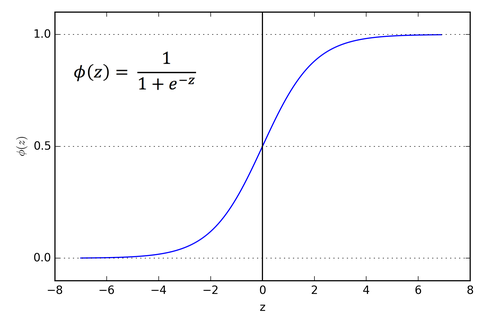

- sigmoid function을 통해 0과 1의 함수로 나타내기 위해 Decision Boundary (threshold)를 설정해줌
  - 해당 threshold를 넘을 경우 class 1, 그렇지 않은 경우 class 0으로 분류
- 예를 들어, threshold를 0.5로 설정하는 경우
  - if p ≥ 0.5, then class = 1
  - if p < 0.5, then class = 0

- multinomial 방식을 사용하는 경우 softmax function을 활용하게 된다.

# Step 1. Data Preprocessing
  - 채점기준 1 : 데이터셋 전처리

## 관측치들 간 독립성(가정1)

- 본 데이터는 각 선수의 시즌 동안의 기록을 나타낸 데이터 이므로 자동으로 충족된다.

In [ ]:
import pandas as pd
basketball = '/content/drive/Shareddrives/22-1 데이터마이닝/data_week4/2021-2022_NBA_Player_Stats.csv'
basketball_origin = pd.read_csv(basketball, sep=';', encoding='latin-1') # 'utf-8'방식이 아닌 'latin-1'방식으로 encoding된 dataset

In [ ]:
basketball_origin.shape # (행, 열)

(784, 30)

In [ ]:
basketball_origin.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Precious Achiuwa,C,22,TOR,60,25,23.2,3.4,7.9,...,0.590,2.1,4.7,6.8,1.1,0.5,0.6,1.2,2.1,8.5
1,2,Steven Adams,C,28,MEM,66,65,26.4,2.9,5.2,...,0.547,4.7,5.2,9.9,3.3,0.8,0.8,1.6,1.9,7.2
2,3,Bam Adebayo,C,24,MIA,45,45,33.0,7.2,13.4,...,0.751,2.4,7.9,10.3,3.5,1.5,0.8,2.8,3.2,19.0
3,4,Santi Aldama,PF,21,MEM,27,0,10.3,1.4,3.6,...,0.600,0.9,1.5,2.4,0.5,0.1,0.3,0.3,1.0,3.3
4,5,LaMarcus Aldridge,C,36,BRK,45,12,22.8,5.6,10.1,...,0.873,1.6,4.0,5.6,0.9,0.3,1.0,0.9,1.6,13.5


In [ ]:
basketball_origin.isnull().sum() # non-null

Rk        0
Player    0
Pos       0
Age       0
Tm        0
G         0
GS        0
MP        0
FG        0
FGA       0
FG%       0
3P        0
3PA       0
3P%       0
2P        0
2PA       0
2P%       0
eFG%      0
FT        0
FTA       0
FT%       0
ORB       0
DRB       0
TRB       0
AST       0
STL       0
BLK       0
TOV       0
PF        0
PTS       0
dtype: int64

Null 값 확인 결과 결측치는 없는 것으로 확인되었다.

In [ ]:
basketball_origin

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Precious Achiuwa,C,22,TOR,60,25,23.2,3.4,7.9,...,0.590,2.1,4.7,6.8,1.1,0.5,0.6,1.2,2.1,8.5
1,2,Steven Adams,C,28,MEM,66,65,26.4,2.9,5.2,...,0.547,4.7,5.2,9.9,3.3,0.8,0.8,1.6,1.9,7.2
2,3,Bam Adebayo,C,24,MIA,45,45,33.0,7.2,13.4,...,0.751,2.4,7.9,10.3,3.5,1.5,0.8,2.8,3.2,19.0
3,4,Santi Aldama,PF,21,MEM,27,0,10.3,1.4,3.6,...,0.600,0.9,1.5,2.4,0.5,0.1,0.3,0.3,1.0,3.3
4,5,LaMarcus Aldridge,C,36,BRK,45,12,22.8,5.6,10.1,...,0.873,1.6,4.0,5.6,0.9,0.3,1.0,0.9,1.6,13.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,593,Thaddeus Young,PF,33,TOR,13,0,17.9,2.5,5.7,...,0.333,1.6,2.8,4.5,1.5,1.0,0.3,1.0,1.8,6.1
780,594,Trae Young,PG,23,ATL,64,64,34.9,9.3,20.4,...,0.900,0.6,3.2,3.8,9.5,1.0,0.1,4.0,1.6,28.0
781,595,Omer Yurtseven,C,23,MIA,49,11,12.8,2.5,4.5,...,0.632,1.5,3.9,5.4,0.9,0.3,0.4,0.8,1.6,5.7
782,596,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,...,0.776,1.9,2.8,4.6,0.8,0.3,0.2,0.7,2.1,5.2


In [ ]:
basketball = basketball_origin.copy() # deep copy

basketball

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Precious Achiuwa,C,22,TOR,60,25,23.2,3.4,7.9,...,0.590,2.1,4.7,6.8,1.1,0.5,0.6,1.2,2.1,8.5
1,2,Steven Adams,C,28,MEM,66,65,26.4,2.9,5.2,...,0.547,4.7,5.2,9.9,3.3,0.8,0.8,1.6,1.9,7.2
2,3,Bam Adebayo,C,24,MIA,45,45,33.0,7.2,13.4,...,0.751,2.4,7.9,10.3,3.5,1.5,0.8,2.8,3.2,19.0
3,4,Santi Aldama,PF,21,MEM,27,0,10.3,1.4,3.6,...,0.600,0.9,1.5,2.4,0.5,0.1,0.3,0.3,1.0,3.3
4,5,LaMarcus Aldridge,C,36,BRK,45,12,22.8,5.6,10.1,...,0.873,1.6,4.0,5.6,0.9,0.3,1.0,0.9,1.6,13.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,593,Thaddeus Young,PF,33,TOR,13,0,17.9,2.5,5.7,...,0.333,1.6,2.8,4.5,1.5,1.0,0.3,1.0,1.8,6.1
780,594,Trae Young,PG,23,ATL,64,64,34.9,9.3,20.4,...,0.900,0.6,3.2,3.8,9.5,1.0,0.1,4.0,1.6,28.0
781,595,Omer Yurtseven,C,23,MIA,49,11,12.8,2.5,4.5,...,0.632,1.5,3.9,5.4,0.9,0.3,0.4,0.8,1.6,5.7
782,596,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,...,0.776,1.9,2.8,4.6,0.8,0.3,0.2,0.7,2.1,5.2


## Pos이 가지는 의미(Binary Target)


- `Pos` 값이 어떻게 분포되어 있는지 확인해보자.

In [ ]:
basketball["Pos"].value_counts()

SG       191
SF       152
PG       150
PF       146
C        129
SF-SG      6
SG-PG      3
SG-SF      3
C-PF       2
PF-SF      1
PG-SG      1
Name: Pos, dtype: int64

포지션이 'SF-SG'와 같이 dual-position을 가지는 경우 '-' 앞의 포지션이 주 포지션이며
 '-' 뒤의 포지션이 부 포지션이라고 판단하였다.
판단의 근거는 위의 배열에서 볼 수 있듯이 'SF-SG' 와 'SG-SF'가 서로 다른 포지션으로 분류되는걸 확인할 수 있기 
때문이다.

### position을 크게 in-position과 out-position으로 변경

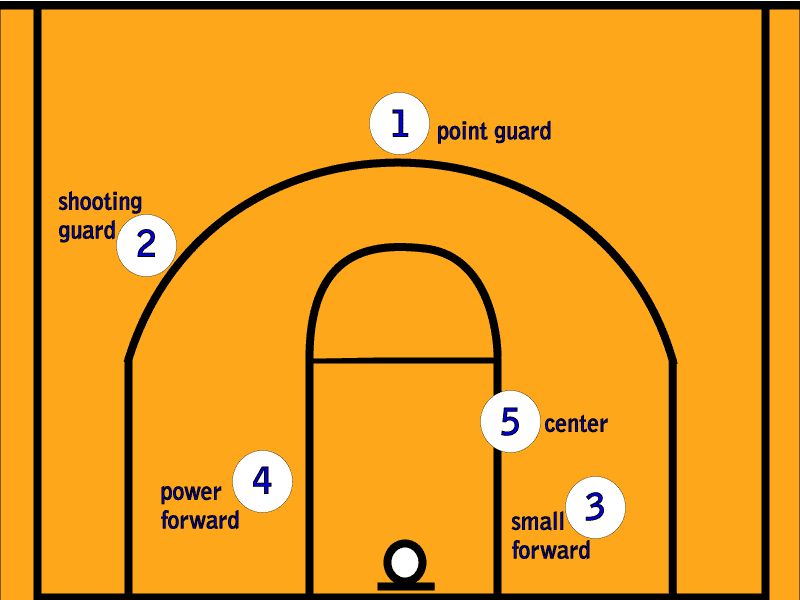

농구 선수들은 경기 중 포지션 기준으로 위의 그림처럼 5명이 각각 하나씩 포지션을 맡게 된다.
- **골대를 기준으로 비교적 멀리서 플레이하는 가드(1)**와
- **가드에 해당하지 않는 나머지(0; 포워드와 센터)**로 구분하여
Logistic Regression을 진행하고자 하였다.
또한 앞서 확인한 것처럼 Dual Position을 가진 경우 먼저 나타난 포지션을 주 포지션으로 판단하여 In/Out 분류를 진행하였다.

In [ ]:
# SG SF PG PF C SF-SG SG-PG SG-SF C-PF PF-SF PG-SG
# in-position: 0(비가드) / out-position: 1(가드)

in_list = ['SF', 'PF', 'C', 'SF-SG', 'C-PF', 'PF-SF']  # 0
out_list = ['PG', 'SG', 'SG-PG', 'SG-SF', 'PG-SG']     # 1

for item in in_list:
    basketball.loc[basketball['Pos'] == item, 'Pos'] = 0

for item in out_list:
    basketball.loc[basketball['Pos'] == item, 'Pos'] = 1

basketball["Pos"].value_counts()

0    436
1    348
Name: Pos, dtype: int64

In [ ]:
basketball

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Precious Achiuwa,0,22,TOR,60,25,23.2,3.4,7.9,...,0.590,2.1,4.7,6.8,1.1,0.5,0.6,1.2,2.1,8.5
1,2,Steven Adams,0,28,MEM,66,65,26.4,2.9,5.2,...,0.547,4.7,5.2,9.9,3.3,0.8,0.8,1.6,1.9,7.2
2,3,Bam Adebayo,0,24,MIA,45,45,33.0,7.2,13.4,...,0.751,2.4,7.9,10.3,3.5,1.5,0.8,2.8,3.2,19.0
3,4,Santi Aldama,0,21,MEM,27,0,10.3,1.4,3.6,...,0.600,0.9,1.5,2.4,0.5,0.1,0.3,0.3,1.0,3.3
4,5,LaMarcus Aldridge,0,36,BRK,45,12,22.8,5.6,10.1,...,0.873,1.6,4.0,5.6,0.9,0.3,1.0,0.9,1.6,13.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,593,Thaddeus Young,0,33,TOR,13,0,17.9,2.5,5.7,...,0.333,1.6,2.8,4.5,1.5,1.0,0.3,1.0,1.8,6.1
780,594,Trae Young,1,23,ATL,64,64,34.9,9.3,20.4,...,0.900,0.6,3.2,3.8,9.5,1.0,0.1,4.0,1.6,28.0
781,595,Omer Yurtseven,0,23,MIA,49,11,12.8,2.5,4.5,...,0.632,1.5,3.9,5.4,0.9,0.3,0.4,0.8,1.6,5.7
782,596,Cody Zeller,0,29,POR,27,0,13.1,1.9,3.3,...,0.776,1.9,2.8,4.6,0.8,0.3,0.2,0.7,2.1,5.2


성공적으로 `Pos` column이 이진 인덱싱이 된 것을 확인할 수 있다.

## 불필요한 Column 제거
  - 분석 이전에 데이터에 등장하는 지표들에 대한 토의를 진행하였고, 포지션의 경우 결국 뛰는 위치를 결정하는 것이기 때문에 위치와 관련이 깊은 변수만을 남기고 나머지 변수는 분석에서 제외하는 것으로 결정하였다. 관련 근거는 아래 사진으로 첨부하였다.

  - `Rk`, `Player`, `Age`, `Tm`, `FG`, `FGA`, `FG%`, `eFG%`, `FT`, `FTA`, `FT%`, `TRB`, `TOV`, `PF`, `PTS` 

    : 포지션에서의 특징으로 나타나는 값과 관계가 적을 것으로 판단되는 값들을 drop 하고자 한다.

  - 하지만 실제 사용하는 변수가 훨씬 적기 때문에 이를 직접 인덱싱하여 사용하였다.


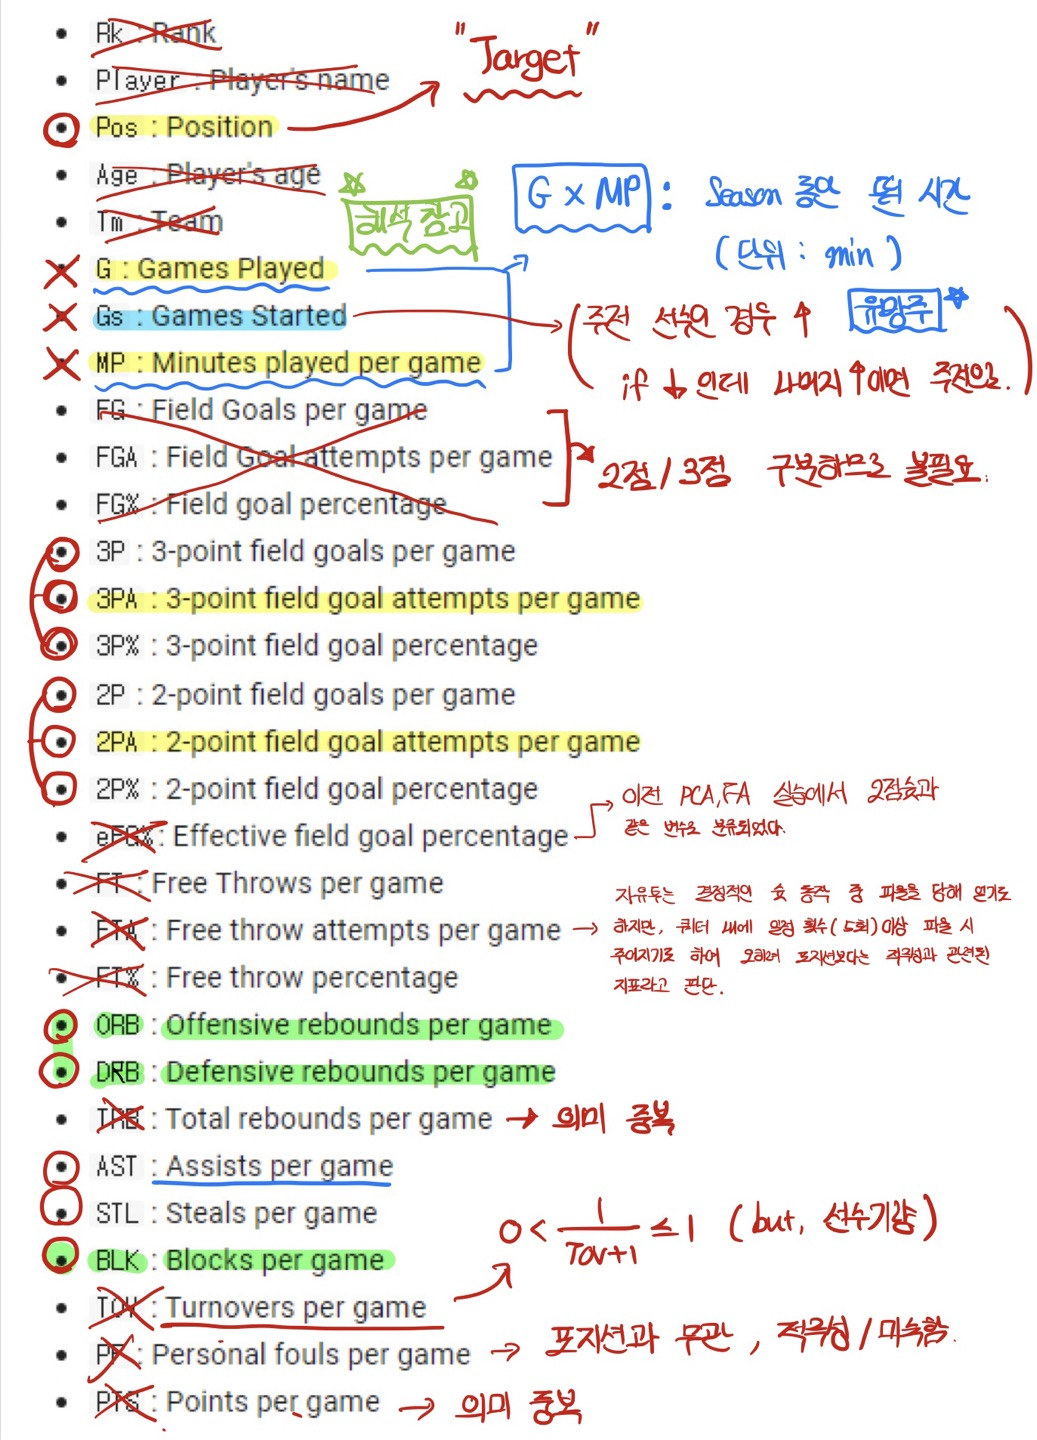

In [ ]:
df = basketball[['Pos','3P', '3PA', '3P%', '2P', '2PA', '2P%', 'AST', 'STL', 'ORB', 'DRB', 'BLK']].copy() # 필요한 속성만 df로 불러옴
df

,Pos,3P,3PA,3P%,2P,2PA,2P%,AST,STL,ORB,DRB,BLK
0,0,0.6,1.6,0.361,2.9,6.3,0.452,1.1,0.5,2.1,4.7,0.6
1,0,0.0,0.0,0.000,2.9,5.2,0.559,3.3,0.8,4.7,5.2,0.8
2,0,0.0,0.1,0.000,7.2,13.3,0.545,3.5,1.5,2.4,7.9,0.8
3,0,0.1,1.4,0.103,1.2,2.1,0.569,0.5,0.1,0.9,1.5,0.3
4,0,0.3,1.0,0.311,5.3,9.1,0.580,0.9,0.3,1.6,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
779,0,0.6,1.3,0.471,1.9,4.4,0.439,1.5,1.0,1.6,2.8,0.3
780,1,3.0,7.8,0.380,6.4,12.6,0.504,9.5,1.0,0.6,3.2,0.1
781,0,0.0,0.1,0.143,2.4,4.4,0.558,0.9,0.3,1.5,3.9,0.4
782,0,0.0,0.1,0.000,1.9,3.2,0.593,0.8,0.3,1.9,2.8,0.2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pos     784 non-null    object 
 1   3P      784 non-null    float64
 2   3PA     784 non-null    float64
 3   3P%     784 non-null    float64
 4   2P      784 non-null    float64
 5   2PA     784 non-null    float64
 6   2P%     784 non-null    float64
 7   AST     784 non-null    float64
 8   STL     784 non-null    float64
 9   ORB     784 non-null    float64
 10  DRB     784 non-null    float64
 11  BLK     784 non-null    float64
dtypes: float64(11), object(1)
memory usage: 73.6+ KB


## **Outlier detection & elimination(가정4)**

- logit linearity를 만족시키기 위해 이상치 탐지를 진행하였다.

- 모든 값들이 선수의 개인 기록이다보니 오히려 Outlier에 해당하는 특징으로 인해 해당 포지션의 특성이 드러날 수도 있다는 판단을 했다.

- 따라서 단순히 Outlier들을 평균이나 중앙값으로 치환하기 보다, 유의미한 값으로 바꿔주는 작업을 진행하였다.

Text(0.5, 1.0, 'Boxplot of all columns')

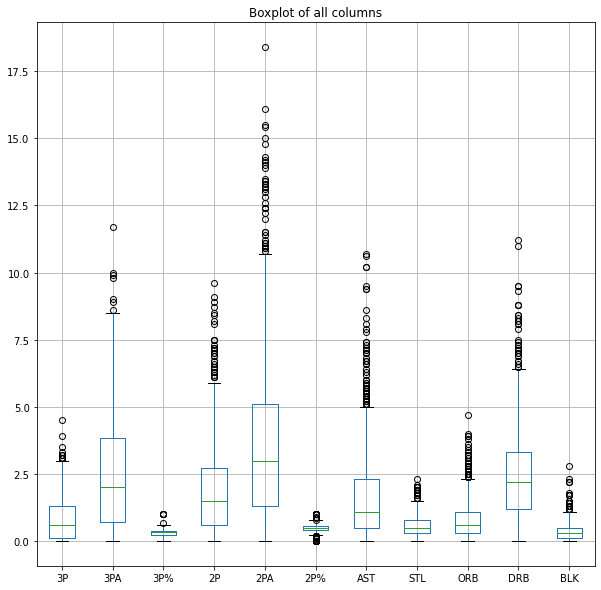

In [ ]:
df.boxplot(figsize=[10, 10]).set_title('Boxplot of all columns')

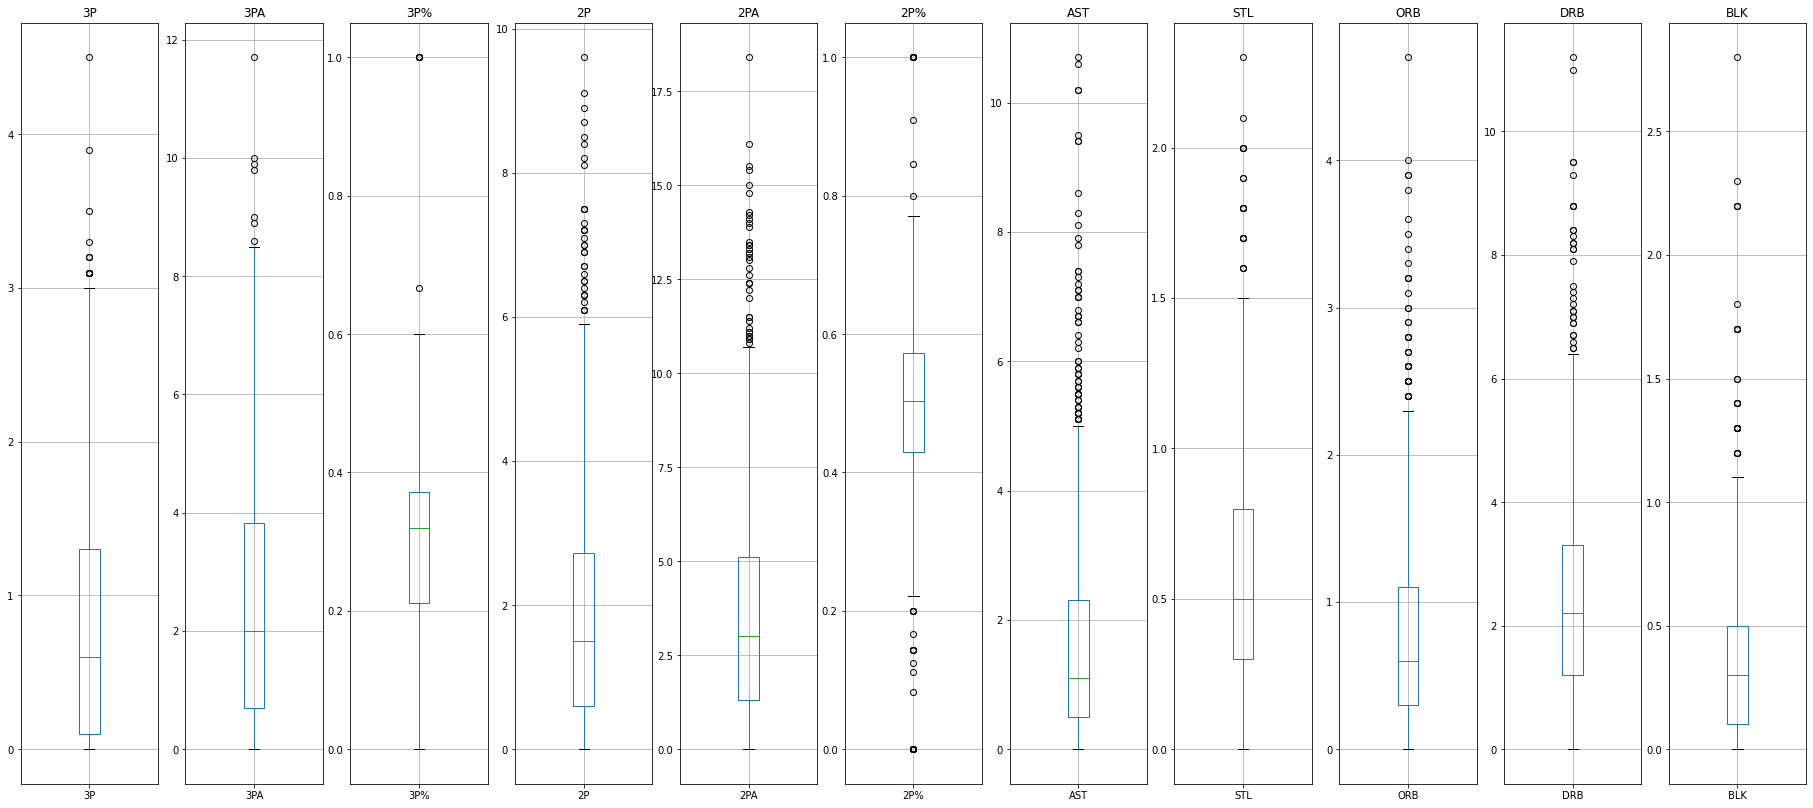

In [ ]:
fig, ax = plt.subplots(ncols=11, figsize=(32, 14))
plot = []

for i in range(11):
    plot.append( df[[ df.columns[i+1] ]].boxplot(ax=ax[i]) )
    plot[i].set_title(df.columns[i+1])

In [ ]:
df_o = df.copy()

이상치 처리 이후 원본과의 대조가 필요한 상황을 위해 데이터를 복사해두었다.

### Outlier replace function
- Boxplot 상에서 바깥 부분에 위치한 Outlier들에 대해 Upper bound와 Lower bound 값으로 대체하는 함수를 정의해주고, 모든 column들에 적용해 주었다.

In [ ]:
def outlier_replace_q1q3(df, param):
    q1, q3 = np.nanpercentile(df[param], [25,75])
    iqr = q3-q1
    lower_bound = q1-(1.5*iqr)
    upper_bound = q3+(1.5*iqr)
    df.loc[df[param] < lower_bound, param] = lower_bound
    df.loc[df[param] > upper_bound, param] = upper_bound

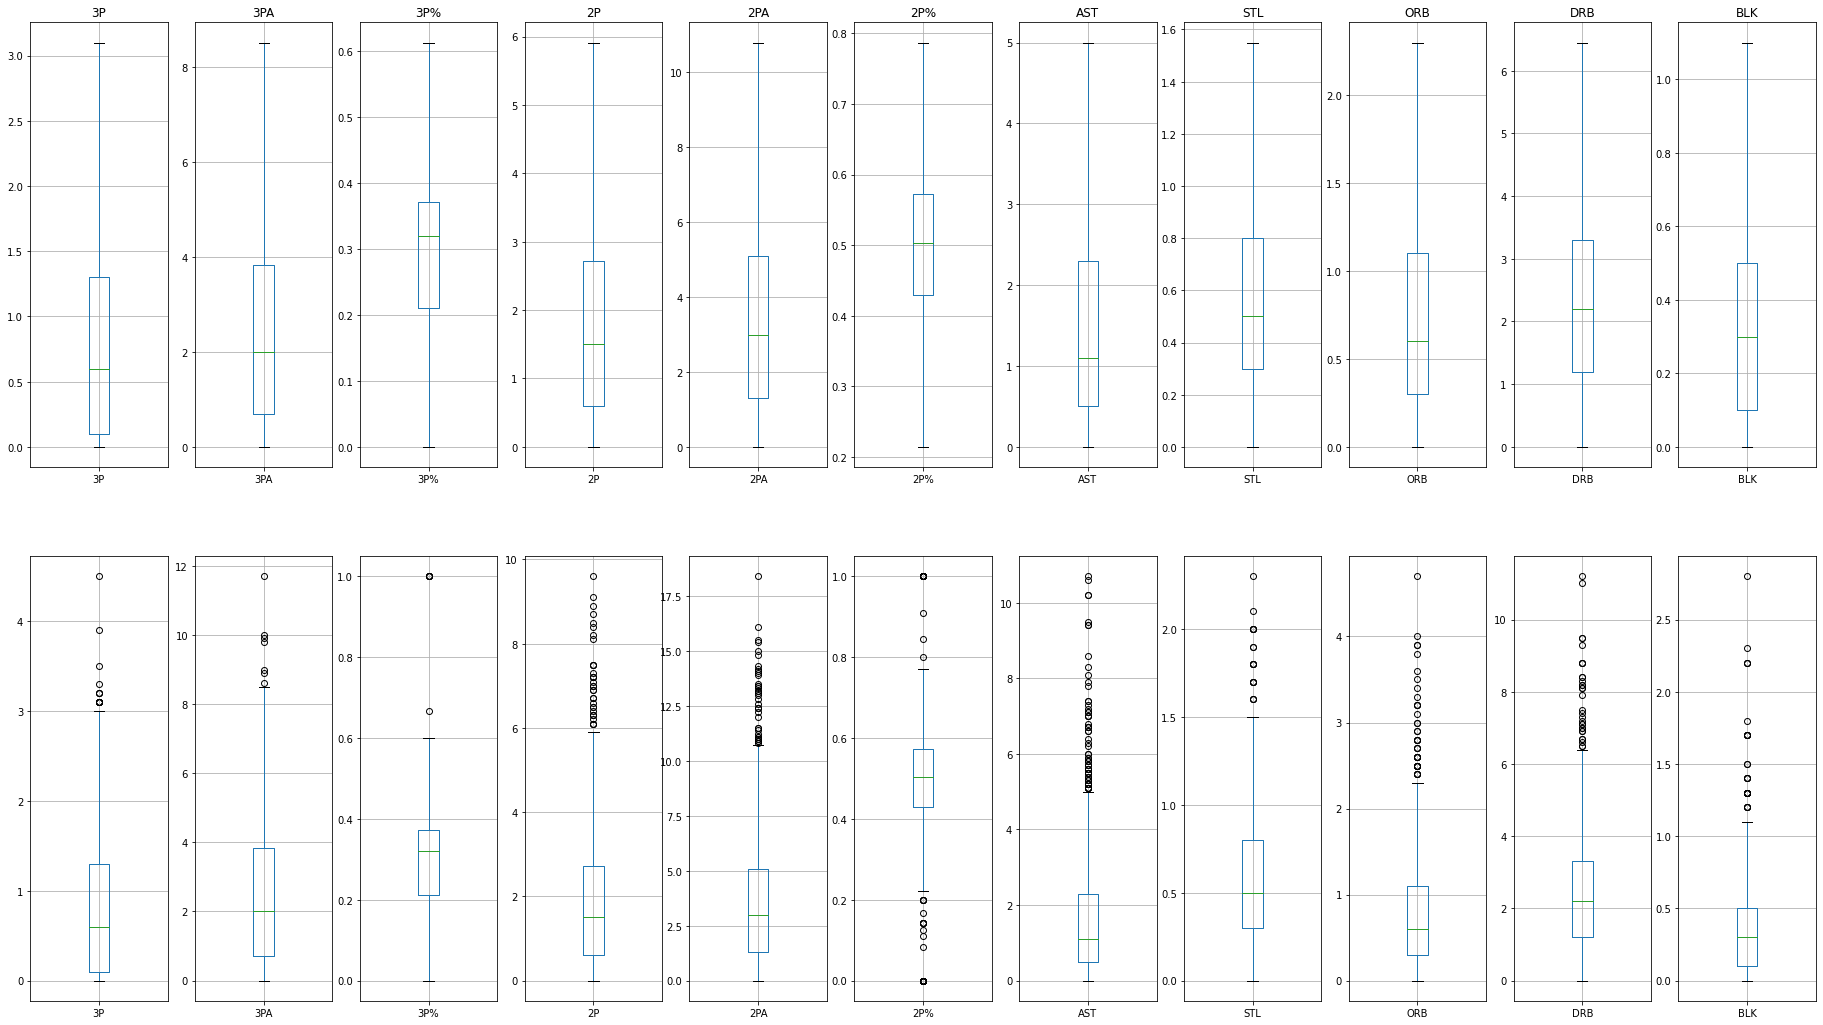

In [ ]:
# 첫째 줄: 변환 결과 / 둘째 줄: 원본

for idx in df.columns[1:]:
    outlier_replace_q1q3(df, idx)

fig, ax = plt.subplots(nrows=2, ncols=11, figsize=(32, 18))
plot2 = []

for i in range(11):

    plot2.append( df[[ df.columns[i+1] ]].boxplot(ax=ax[0, i]) )
    plot2[i].set_title(df.columns[i+1])

    plot.append( df_o[[ df_o.columns[i+1] ]].boxplot(ax=ax[1, i]) )
    plot[i].set_title(df_o.columns[i+1])

# Step 2. EDA


## 각 설명변수와 종속변수의 분포를 살펴보기

- 설명변수가 모두 연속형 변수인 관계로 plot만을 그려보았다.

각 변수의 분포 그래프를 그리는 함수를 따로 정의해주었다.

In [ ]:
def facetGrid(df, param, hue='Pos'):
    facet = sns.FacetGrid(df, hue=hue, aspect=4)
    facet.map(sns.kdeplot, param, shade=True)
    facet.set(xlim=(0, df[param].max()))
    facet.add_legend()
    sns.axes_style("darkgrid")
    plt.show()

### 3P - Pos 

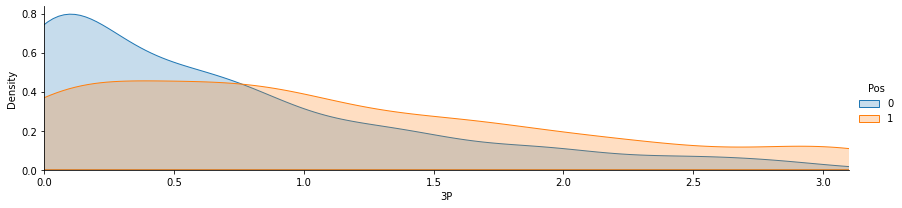

In [ ]:
# 3P에 따른 Pos (0: Gurad, 1: Else)비교

facetGrid(df, '3P')

### 3PA - Pos 

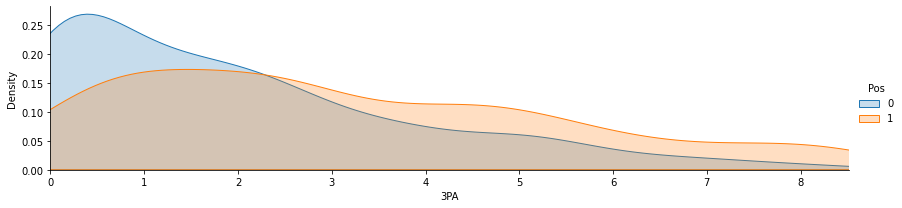

In [ ]:
# 3PA에 따른 Pos (0: Gurad, 1: Else)비교

facetGrid(df, '3PA')

### 3P% - Pos 

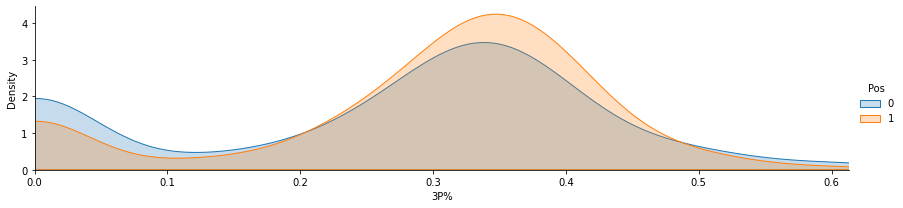

In [ ]:
# 3P%에 따른 Pos (0: Gurad, 1: Else)비교

facetGrid(df, '3P%')

### 2P - Pos 

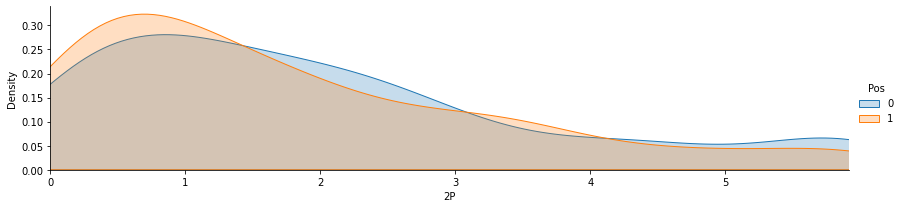

In [ ]:
# 2P에 따른 Pos (0: Gurad, 1: Else)비교

facetGrid(df, '2P')

### 2PA - Pos 

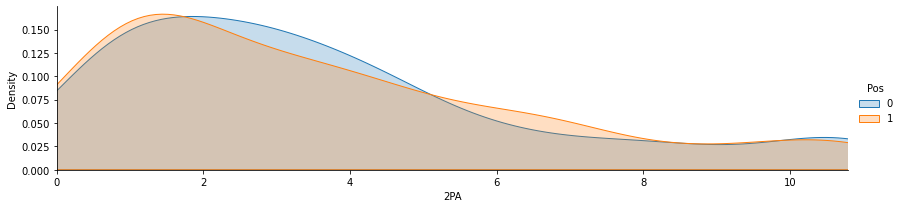

In [ ]:
# 2PA에 따른 Pos (0: Gurad, 1: Else)비교

facetGrid(df, '2PA')

### 2P% - Pos 

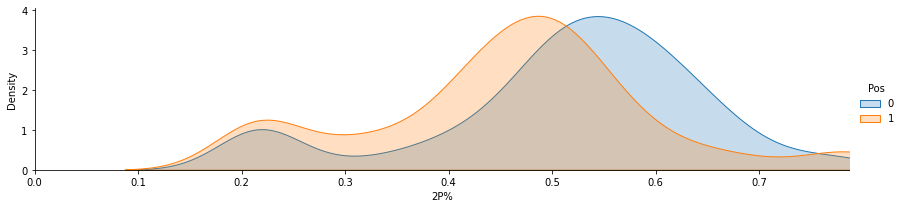

In [ ]:
# 2P%에 따른 Pos (0: Gurad, 1: Else)비교

facetGrid(df, '2P%')

### AST - Pos 

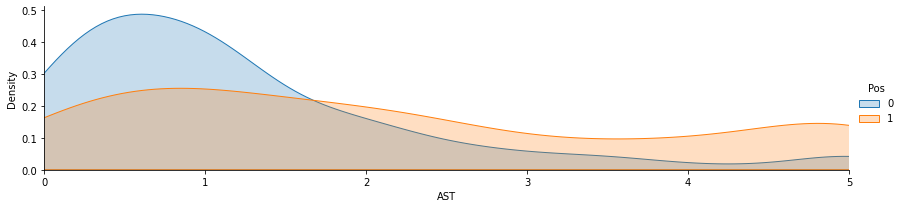

In [ ]:
# AST에 따른 Pos (0: Gurad, 1: Else)비교

facetGrid(df, 'AST')

### STL - Pos 

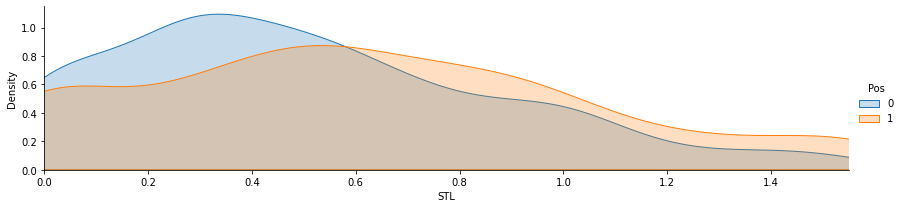

In [ ]:
# STL에 따른 Pos (0: Gurad, 1: Else)비교

facetGrid(df, 'STL')

### ORB - Pos 

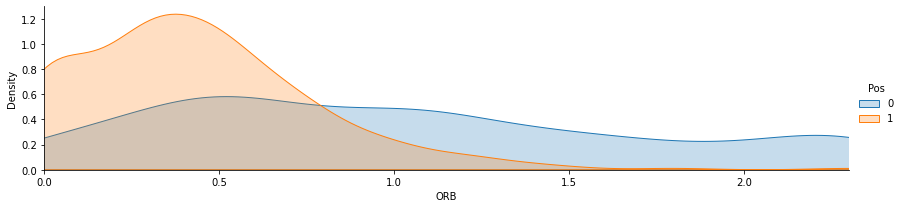

In [ ]:
# ORB에 따른 Pos (0: Gurad, 1: Else)비교

facetGrid(df, 'ORB')

### DRB - Pos 

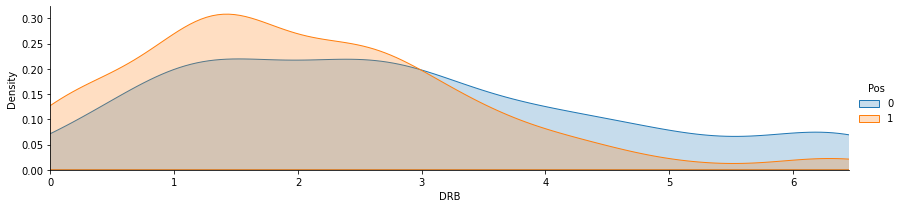

In [ ]:
# DRB에 따른 Pos (0: Gurad, 1: Else)비교

facetGrid(df, 'DRB')

### BLK - Pos 

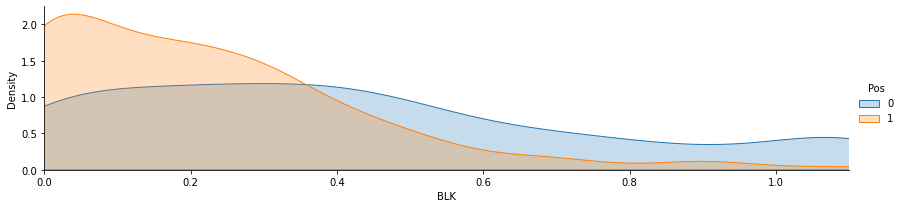

In [ ]:
# BLK에 따른 Pos (0: Gurad, 1: Else)비교

facetGrid(df, 'BLK')

## **VIF 확인**

- $VIF = 1/(1-(R_j)^2)$
- $VIF > 10$
  

VIF 값을 확인하여 모델에 필요한 변수를 선택해준다. 또한 VIF 계산 시 설명변수들만을 사용함에 유의하도록 하자.

- 다중공선성이 의심되는 변수 : `3P`, `3PA`, `2P`, `2PA`, `DRB`

In [ ]:
# Use variance inflation factor to identify any significant multi-collinearity
def calc_vif(X):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

# df.shape[1] : df의 column의 개수

calc_vif(df.drop(columns=['Pos'])) # VIF 계산 시 설명변수들만을 사용한다.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,variables,VIF
0,3P,48.939337
1,3PA,54.243511
2,3P%,6.602168
3,2P,83.427036
4,2PA,96.891603
5,2P%,8.012198
6,AST,7.968961
7,STL,6.618157
8,ORB,7.650306
9,DRB,15.307172


VIF가 10보다 높게 등장한 변수를 제외하고 학습을 진행하도록 하자.

In [ ]:
# 유의미하다고 생각되는 column 선택

df = df[['Pos','2P%','3P%', 'AST', 'STL', 'ORB', 'BLK']]

df.columns

Index(['Pos', '2P%', '3P%', 'AST', 'STL', 'ORB', 'BLK'], dtype='object')

In [ ]:
calc_vif(df.drop(columns=['Pos'])) # VIF 계산 시 설명변수들만을 사용한다.

,variables,VIF
0,2P%,6.013165
1,3P%,4.140096
2,AST,4.277093
3,STL,6.170328
4,ORB,4.387813
5,BLK,4.319584


전체적으로 VIF 값이 7 미만에 있음을 확인할 수 있다.

# Step 3. Logistic Regression 
- 설명이 용이함
  - 오즈(odds; $\frac{p}{1-p}$)의 관점에서 해석될 수 있음 (실패에 비해 성공할 확률의 비)
  - $exp(\beta_1)$: 나머지 변수$(x_2,\cdots,x_k)$가 주어질 때 $x_1$이 한 단위 증가할 때마다 성공(Y)의 오즈가 몇 배 증가하는지를 나타내는 값
- 좋은 성능을 기대하기 어려울 수도 있음
- `statsmodel`, `sklearn`
  - `statsmodel`: p-value 등 모델에 대한 summary 정보 제공

In [ ]:
train_features = df[['2P%','3P%', 'AST', 'STL', 'ORB', 'BLK']]
train_target = df['Pos']
train_target = train_target.astype('int')

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_features, train_target, test_size = 0.2, random_state = 312)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.25, random_state = 312, stratify=y_train)
print("train set:",x_train.shape)
print("valid set:",x_valid.shape)
print("test set:",x_test.shape)

train set: (470, 6)
valid set: (157, 6)
test set: (157, 6)


In [ ]:
y_train.value_counts() # 0: 포워드,센터, 1: 가드

0    265
1    205
Name: Pos, dtype: int64

In [ ]:
# Target variable의 0과 1 값읆 맞춰주기 위해 Random Oversampling

from imblearn.over_sampling import RandomOverSampler
x_train, y_train = RandomOverSampler(random_state=312).fit_resample(x_train, y_train)

In [ ]:
y_train.value_counts() # 0: 포워드,센터, 1: 가드

0    265
1    265
Name: Pos, dtype: int64

In [ ]:
import statsmodels.api as sm
x_train = sm.add_constant(x_train)
x_valid = sm.add_constant(x_valid)
x_test = sm.add_constant(x_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
model_sm = sm.Logit(y_train, x_train).fit()

Optimization terminated successfully.
         Current function value: 0.392622
         Iterations 7


# Step 4. Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Probability 값
predict_prob = model_sm.predict(x_valid)

In [ ]:
y_valid.shape

(157,)

### 잔차간 등분산성 검정(가정2)
- 예측값(fitted)과 잔차(residual)를 비교
- 빨간 실선은 잔차의 추세를 나타냄
- 모든 예측값에서 가운데 점선에 맞추어 잔차가 비슷하게 있어야 하며, 빨간 실선이 점선에서 크게 벗어난다면 예측값에 따라 잔차가 크게 달라짐 = 선형성이 없음

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


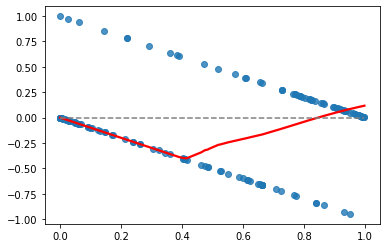

In [ ]:
residual = y_valid - predict_prob

sns.regplot(predict_prob, residual, lowess=True, line_kws={'color': 'red'})
plt.plot([predict_prob.min(), predict_prob.max()], [0, 0], '--', color='grey')

빨간 실선이 점선과 완전히 일치하지는 않았지만 대체로 크게 벗어나지는 않았다.

## logit linearity 확인(가정3)

### 3P% : 선형성이 거의 나타나지 않음


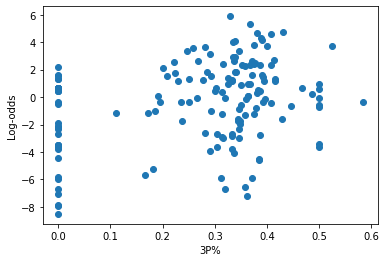

In [ ]:
import numpy as np
# Getting log odds values
log_odds = np.log(predict_prob / (1 - predict_prob))

# Visualize predictor variable vs logit values
plt.scatter(x=x_valid['3P%'].values, y=log_odds)
plt.xlabel("3P%")
plt.ylabel("Log-odds")
plt.show()

### 2P% : 약한 선형성이 나타남

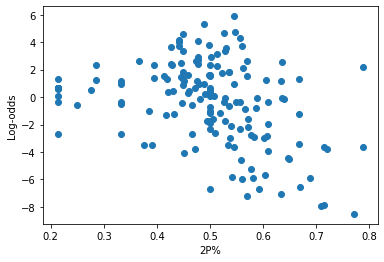

In [ ]:
import numpy as np
# Getting log odds values
log_odds = np.log(predict_prob / (1 - predict_prob))

# Visualize predictor variable vs logit values
plt.scatter(x=x_valid['2P%'].values, y=log_odds)
plt.xlabel("2P%")
plt.ylabel("Log-odds")
plt.show()

### AST : 선형성이 나타남

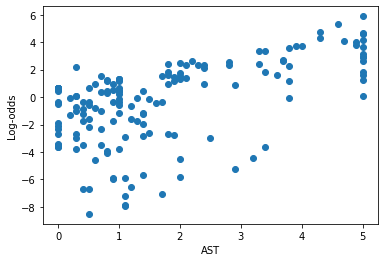

In [ ]:
import numpy as np
# Getting log odds values
log_odds = np.log(predict_prob / (1 - predict_prob))

# Visualize predictor variable vs logit values
plt.scatter(x=x_valid['AST'].values, y=log_odds)
plt.xlabel("AST")
plt.ylabel("Log-odds")
plt.show()

### STL : 약한 선형성이 나타남

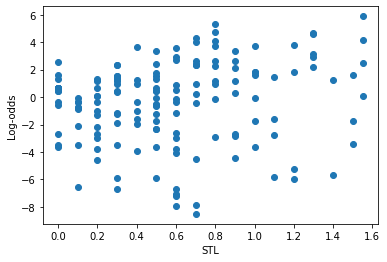

In [ ]:
import numpy as np
# Getting log odds values
log_odds = np.log(predict_prob / (1 - predict_prob))

# Visualize predictor variable vs logit values
plt.scatter(x=x_valid['STL'].values, y=log_odds)
plt.xlabel("STL")
plt.ylabel("Log-odds")
plt.show()

### ORB : 선형성이 나타남

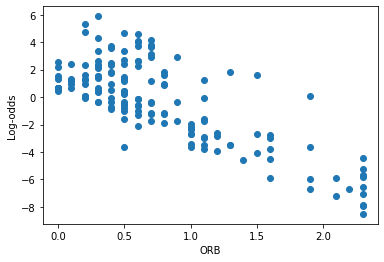

In [ ]:
import numpy as np
# Getting log odds values
log_odds = np.log(predict_prob / (1 - predict_prob))

# Visualize predictor variable vs logit values
plt.scatter(x=x_valid['ORB'].values, y=log_odds)
plt.xlabel("ORB")
plt.ylabel("Log-odds")
plt.show()

### BLK : 약한 선형성이 나타남

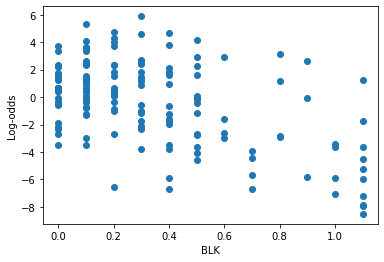

In [ ]:
import numpy as np
# Getting log odds values
log_odds = np.log(predict_prob / (1 - predict_prob))

# Visualize predictor variable vs logit values for Age
plt.scatter(x=x_valid['BLK'].values, y=log_odds)
plt.xlabel("BLK")
plt.ylabel("Log-odds")
plt.show()

## 적절한 cut-off 설정(채점기준2)

최근 농구에서는 포지션의 경계가 많이 허물어지고는 있지만, 외곽에서 주로 플레이를 많이 하는 가드와 골대 근방에서 플레이하는 포워드나 센터에 대한 예측은 새로운 선수를 적절한 포지션에 배치하는 데 유효할 수 있다. 특히 0과 1 분류가 모두 균형있게 이루어지는 것이 권장되므로 precision_score와 recall_score의 조화평균인 f1_score값을 기준으로 이 값이 가장 높은 cut-off를 찾아보려고 한다.

In [ ]:
# 경계값 cut off value에 따라 0,1 값 변환

def change_cutoff(pred_prob_y, cutoff):
    Y_change = pred_prob_y.copy()
    Y_change[Y_change > cutoff] = 1
    Y_change[Y_change <= cutoff] = 0
    return(Y_change.astype(int))

In [ ]:
max_idx = 0
max_f1 = 0
# cutoff : 0.01 ~ 0.99 탐색
for i in range(1, 100):
  idx = i
  f1 = f1_score(y_valid, change_cutoff(predict_prob, 0.01*float(i)))
  if max_f1 < f1:
    max_idx = idx
    max_f1 = f1
print(max_idx, max_f1)

71 0.8062015503875969


탐색 결과 `cutoff=0.71` 일때 f1_score값이 가장 높게 등장하였다.

`cutoff=0.71`일때 Confusion Matrix와 accuracy_score, precision_score, recall_score, f1_score를 출력해보면 다음과 같다.

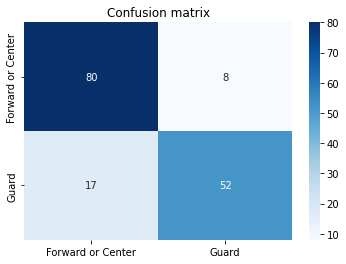

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

conf_m = pd.DataFrame(confusion_matrix(y_valid, change_cutoff(predict_prob, 0.01*max_idx)), columns=['Forward or Center','Guard'], index=['Forward or Center','Guard'])
f = sns.heatmap(conf_m, annot=True, cmap=cm.Blues).set_title('Confusion matrix')

In [ ]:
cut_max = [[accuracy_score(y_valid, change_cutoff(predict_prob, 0.01*max_idx)), 
          precision_score(y_valid, change_cutoff(predict_prob, 0.01*max_idx)),
          recall_score(y_valid, change_cutoff(predict_prob, 0.01*max_idx)),
          f1_score(y_valid, change_cutoff(predict_prob, 0.01*max_idx))]]
pd.DataFrame(cut_max, columns=['accuracy_score','precision_score','recall_score','f1_score'], index=['values(0~1)'])

,accuracy_score,precision_score,recall_score,f1_score
values(0~1),0.840764,0.866667,0.753623,0.806202


- ROC curve: 다양한 threshold에 대한 이진분류기의 성능을 한번에 표시한 그래프
  - TPR: true positive rate
  - FPR: false positive rate
  - 좌측 상단으로 붙어있는 경우 좋은 분류기
- [참고](https://angeloyeo.github.io/2020/08/05/ROC.html)

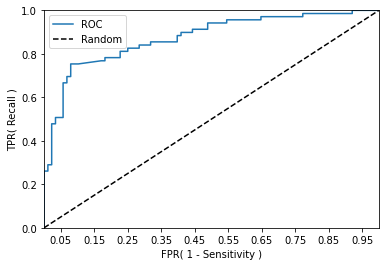

In [ ]:
from sklearn.metrics import roc_curve

def roc_curve_plot(y_test , pred_proba_c1):
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1) # 임곗값에 따른 FPR, TPR 값을 반환 받음. 

    plt.plot(fprs , tprs, label='ROC')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
  
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )')
    plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
  
roc_curve_plot(y_valid, predict_prob)

# Step 5. Interpretation


In [ ]:
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Pos   No. Observations:                  530
Model:                          Logit   Df Residuals:                      523
Method:                           MLE   Df Model:                            6
Date:                Sat, 30 Apr 2022   Pseudo R-squ.:                  0.4336
Time:                        03:39:07   Log-Likelihood:                -208.09
converged:                       True   LL-Null:                       -367.37
Covariance Type:            nonrobust   LLR p-value:                 8.609e-66
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8498      0.442      1.923      0.055      -0.016       1.716
2P%           -0.8156      0.820     -0.994      0.320      -2.423       0.792
3P%           -0.1108      0.875     -0.127      0.899      -1.827       1.605
AST            1.0436      0.149      7.002      0.000       0.751       1.336
STL            1.2723      0.460      2.765      0.006       0.370       2.174
ORB           -3.3760      0.411     -8.222      0.000      -4.181      -2.571
BLK           -2.1708      0.679     -3.197      0.001      -3.501      -0.840
==============================================================================
"""

In [ ]:
model_sm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.434     
Dependent Variable: Pos              AIC:              430.1791  
Date:               2022-04-30 03:39 BIC:              460.0892  
No. Observations:   530              Log-Likelihood:   -208.09   
Df Model:           6                LL-Null:          -367.37   
Df Residuals:       523              LLR p-value:      8.6094e-66
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const      0.8498     0.4420    1.9227   0.0545   -0.0165    1.7160
2P%       -0.8156     0.8203   -0.9943   0.3201   -2.4235    0.7922
3P%       -0.1108     0.8754   -0.1266   0.8993   -1.8266    1.6050
AST        1.0436     0.1490    7.0016   0.0000    0.7514    1.3357
STL        1.2723     0.4601    2.7652   0.0057    0.3705    2.1741
ORB       -3.3760     0.4106   -8.2225   0.0000   -4.1807   -2.5713
BLK       -2.1708     0.6789   -3.1973   0.0014   -3.5014   -0.8401
=================================================================

"""

- `3P%`에서 logit linearity가 충족되지 않은 점
- `2P%`과 `3P%`의 P-value가 0.05를 초과하는 점

때문에 더 이상의 해석을 진행하기에 앞서 해당 Column들을 빼고 다시 모델을 만들어야할 필요가 있다고 판단하였다. 

# Step 6.1 Logistic Regression(2)
- 앞선 모델에서 `3P%` column을 제거한 모델을 다시 만들어 성능을 확인하였다.
- Logit linearity는 앞에서 이미 확인하였으므로 나머지 과정만 동일하게 진행하였다.




In [ ]:
train_features2 = df[['2P%', 'AST', 'STL', 'ORB', 'BLK']]

train_target2 = df['Pos']
train_target2 = train_target2.astype('int')

In [ ]:
from sklearn.model_selection import train_test_split
x_train2, x_test2, y_train2, y_test2 = train_test_split(train_features2, train_target2, test_size = 0.2, random_state = 312)
x_train2, x_valid2, y_train2, y_valid2 = train_test_split(x_train2, y_train2, test_size = 0.25, random_state = 312, stratify=y_train2)
print("train set:",x_train2.shape)
print("valid set:",x_valid2.shape)
print("test set:",x_test2.shape)

train set: (470, 5)
valid set: (157, 5)
test set: (157, 5)


In [ ]:
y_train2.value_counts() # 0: 포워드,센터, 1: 가드

0    265
1    205
Name: Pos, dtype: int64

In [ ]:
from imblearn.over_sampling import RandomOverSampler
x_train2, y_train2 = RandomOverSampler(random_state=312).fit_resample(x_train2, y_train2)

In [ ]:
y_train2.value_counts() # 0: 포워드,센터, 1: 가드

0    265
1    265
Name: Pos, dtype: int64

In [ ]:
import statsmodels.api as sm
x_train2 = sm.add_constant(x_train2)
x_valid2 = sm.add_constant(x_valid2)
x_test2 = sm.add_constant(x_test2)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
model_sm_2 = sm.Logit(y_train2, x_train2).fit()
# model_sm = smf.logit("y 변수명 ~ X변수1 + X변수2", data=데이터프레임).fit()의 형태로도 fit 가능

Optimization terminated successfully.
         Current function value: 0.392637
         Iterations 7


In [ ]:
# Probability 값
predict_prob2 = model_sm_2.predict(x_valid2)

In [ ]:
y_valid2.shape

(157,)

In [ ]:
max_idx2 = 0
max_f1_2 = 0
# cutoff : 0.01 ~ 0.99 탐색
for i in range(1, 100):
  idx = i
  f1 = f1_score(y_valid2, change_cutoff(predict_prob2, 0.01*float(i)))
  if max_f1_2 < f1:
    max_idx2 = idx
    max_f1_2 = f1
print(max_idx2, max_f1_2)

71 0.8062015503875969


탐색 결과 앞의 결과와 마찬가지로 `cutoff=0.71` 일때 f1_score값이 가장 높게 등장하였다.

`cutoff=0.71`일때 Confusion Matrix와 accuracy_score, precision_score, recall_score, f1_score를 출력해보면 다음과 같다.

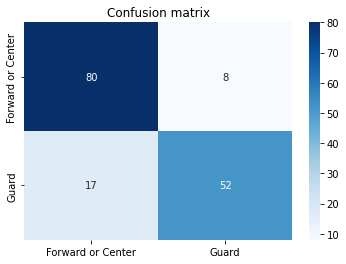

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

conf_m = pd.DataFrame(confusion_matrix(y_valid2, change_cutoff(predict_prob2, 0.01*max_idx)), columns=['Forward or Center','Guard'], index=['Forward or Center','Guard'])
f = sns.heatmap(conf_m, annot=True, cmap=cm.Blues).set_title('Confusion matrix')

In [ ]:
cut_max = [[accuracy_score(y_valid2, change_cutoff(predict_prob2, 0.01*max_idx2)), 
          precision_score(y_valid2, change_cutoff(predict_prob2, 0.01*max_idx2)),
          recall_score(y_valid2, change_cutoff(predict_prob2, 0.01*max_idx2)),
          f1_score(y_valid2, change_cutoff(predict_prob2, 0.01*max_idx2))]]
pd.DataFrame(cut_max, columns=['accuracy_score','precision_score','recall_score','f1_score'], index=['values(0~1)'])

,accuracy_score,precision_score,recall_score,f1_score
values(0~1),0.840764,0.866667,0.753623,0.806202


- ROC curve: 다양한 threshold에 대한 이진분류기의 성능을 한번에 표시한 그래프
  - TPR: true positive rate
  - FPR: false positive rate
  - 좌측 상단으로 붙어있는 경우 좋은 분류기
- [참고](https://angeloyeo.github.io/2020/08/05/ROC.html)

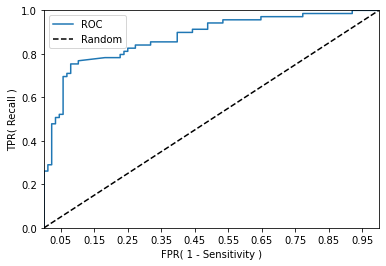

In [ ]:
roc_curve_plot(y_valid2, predict_prob2)

In [ ]:
model_sm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Pos   No. Observations:                  530
Model:                          Logit   Df Residuals:                      524
Method:                           MLE   Df Model:                            5
Date:                Sat, 30 Apr 2022   Pseudo R-squ.:                  0.4335
Time:                        03:39:10   Log-Likelihood:                -208.10
converged:                       True   LL-Null:                       -367.37
Covariance Type:            nonrobust   LLR p-value:                 1.031e-66
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8301      0.413      2.010      0.044       0.021       1.640
2P%           -0.8213      0.819     -1.003      0.316      -2.426       0.783
AST            1.0413      0.148      7.043      0.000       0.751       1.331
STL            1.2689      0.459      2.766      0.006       0.370       2.168
ORB           -3.3826      0.408     -8.296      0.000      -4.182      -2.583
BLK           -2.1729      0.679     -3.201      0.001      -3.503      -0.842
==============================================================================
"""

In [ ]:
model_sm_2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.434     
Dependent Variable: Pos              AIC:              428.1951  
Date:               2022-04-30 03:39 BIC:              453.8323  
No. Observations:   530              Log-Likelihood:   -208.10   
Df Model:           5                LL-Null:          -367.37   
Df Residuals:       524              LLR p-value:      1.0313e-66
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const      0.8301     0.4130    2.0099   0.0444    0.0206    1.6395
2P%       -0.8213     0.8187   -1.0031   0.3158   -2.4260    0.7834
AST        1.0413     0.1479    7.0426   0.0000    0.7515    1.3311
STL        1.2689     0.4588    2.7658   0.0057    0.3697    2.1681
ORB       -3.3826     0.4077   -8.2958   0.0000   -4.1817   -2.5834
BLK       -2.1729     0.6788   -3.2011   0.0014   -3.5032   -0.8425
=================================================================

"""

`2P%`의 P-value가 이번에도 0.05를 초과하였기 때문에, 마찬가지로 해당 Column을 빼고 모델을 다시 만들어보았다.

# Step 6.2 Logistic Regression(3)


In [ ]:
train_features3 = df[['AST', 'STL', 'ORB', 'BLK']]

train_target3 = df['Pos']
train_target3 = train_target3.astype('int')

In [ ]:
from sklearn.model_selection import train_test_split
x_train3, x_test3, y_train3, y_test3 = train_test_split(train_features3, train_target3, test_size = 0.2, random_state = 312)
x_train3, x_valid3, y_train3, y_valid3 = train_test_split(x_train3, y_train3, test_size = 0.25, random_state = 312, stratify=y_train3)
print("train set:",x_train3.shape)
print("valid set:",x_valid3.shape)
print("test set:",x_test3.shape)

train set: (470, 4)
valid set: (157, 4)
test set: (157, 4)


In [ ]:
y_train3.value_counts() # 0: 포워드,센터, 1: 가드

0    265
1    205
Name: Pos, dtype: int64

In [ ]:
from imblearn.over_sampling import RandomOverSampler
x_train3, y_train3 = RandomOverSampler(random_state=312).fit_resample(x_train3, y_train3)

In [ ]:
y_train3.value_counts() # 0: 포워드,센터, 1: 가드

0    265
1    265
Name: Pos, dtype: int64

In [ ]:
import statsmodels.api as sm
x_train3 = sm.add_constant(x_train3)
x_valid3 = sm.add_constant(x_valid3)
x_test3 = sm.add_constant(x_test3)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
model_sm_3 = sm.Logit(y_train3, x_train3).fit()
# model_sm = smf.logit("y 변수명 ~ X변수1 + X변수2", data=데이터프레임).fit()의 형태로도 fit 가능

Optimization terminated successfully.
         Current function value: 0.393585
         Iterations 7


In [ ]:
# Probability 값
predict_prob3 = model_sm_3.predict(x_valid3)

In [ ]:
y_valid3.shape

(157,)

In [ ]:
max_idx3 = 0
max_f1_3 = 0
# cutoff : 0.01 ~ 0.99 탐색
for i in range(1, 100):
  idx = i
  f1 = f1_score(y_valid3, change_cutoff(predict_prob3, 0.01*float(i)))
  if max_f1_3 < f1:
    max_idx3 = idx
    max_f1_3 = f1
print(max_idx3, max_f1_3)

71 0.8062015503875969


탐색 결과 앞의 결과와 마찬가지로 `cutoff=0.71` 일때 f1_score값이 가장 높게 등장하였다.

`cutoff=0.71`일때 Confusion Matrix와 accuracy_score, precision_score, recall_score, f1_score를 출력해보면 다음과 같다.

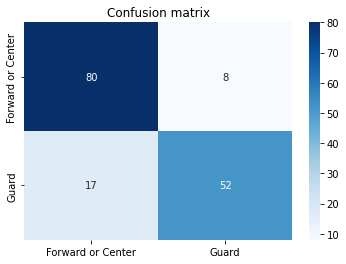

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

conf_m = pd.DataFrame(confusion_matrix(y_valid3, change_cutoff(predict_prob3, 0.01*max_idx)), columns=['Forward or Center','Guard'], index=['Forward or Center','Guard'])
f = sns.heatmap(conf_m, annot=True, cmap=cm.Blues).set_title('Confusion matrix')

In [ ]:
cut_max = [[accuracy_score(y_valid3, change_cutoff(predict_prob3, 0.01*max_idx3)), 
          precision_score(y_valid3, change_cutoff(predict_prob3, 0.01*max_idx3)),
          recall_score(y_valid3, change_cutoff(predict_prob3, 0.01*max_idx3)),
          f1_score(y_valid3, change_cutoff(predict_prob3, 0.01*max_idx3))]]
pd.DataFrame(cut_max, columns=['accuracy_score','precision_score','recall_score','f1_score'], index=['values(0~1)'])

,accuracy_score,precision_score,recall_score,f1_score
values(0~1),0.840764,0.866667,0.753623,0.806202


- ROC curve: 다양한 threshold에 대한 이진분류기의 성능을 한번에 표시한 그래프
  - TPR: true positive rate
  - FPR: false positive rate
  - 좌측 상단으로 붙어있는 경우 좋은 분류기
- [참고](https://angeloyeo.github.io/2020/08/05/ROC.html)

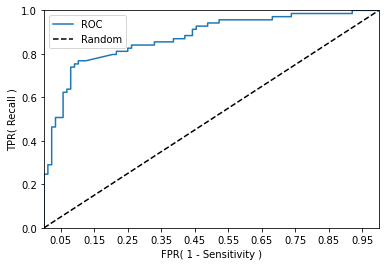

In [ ]:
roc_curve_plot(y_valid3, predict_prob3)

In [ ]:
model_sm_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Pos   No. Observations:                  530
Model:                          Logit   Df Residuals:                      525
Method:                           MLE   Df Model:                            4
Date:                Sat, 30 Apr 2022   Pseudo R-squ.:                  0.4322
Time:                        03:39:13   Log-Likelihood:                -208.60
converged:                       True   LL-Null:                       -367.37
Covariance Type:            nonrobust   LLR p-value:                 1.785e-67
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4790      0.214      2.241      0.025       0.060       0.898
AST            1.0576      0.147      7.177      0.000       0.769       1.346
STL            1.2397      0.455      2.727      0.006       0.349       2.131
ORB           -3.4330      0.406     -8.456      0.000      -4.229      -2.637
BLK           -2.2448      0.674     -3.331      0.001      -3.566      -0.924
==============================================================================
"""

In [ ]:
model_sm_3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.432     
Dependent Variable: Pos              AIC:              427.2006  
Date:               2022-04-30 03:39 BIC:              448.5650  
No. Observations:   530              Log-Likelihood:   -208.60   
Df Model:           4                LL-Null:          -367.37   
Df Residuals:       525              LLR p-value:      1.7846e-67
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const      0.4790     0.2137    2.2409   0.0250    0.0600    0.8979
AST        1.0576     0.1474    7.1772   0.0000    0.7688    1.3464
STL        1.2397     0.4546    2.7272   0.0064    0.3487    2.1306
ORB       -3.4330     0.4060   -8.4558   0.0000   -4.2287   -2.6372
BLK       -2.2448     0.6740   -3.3306   0.0009   -3.5658   -0.9238
=================================================================

"""

모든 변수의 P-value가 0.05 미만임을 확인할 수 있다. 해당 모델은 나머지 가정들도 모두 만족하는 모델이므로, 최종적으로 모델에 대한 해석을 진행하였다.

# Step 7. Final Interpretation

### Regression Coefficient


In [ ]:
# Odds ratio

import numpy as np
np.exp(model_sm_3.params)

const    1.614401
AST      2.879421
STL      3.454423
ORB      0.032291
BLK      0.105952
dtype: float64

- ${e^{AST}}$ = 2.88 :
  AST 1단위가 늘 수록 가드로 분류될 확률이 2.88배 증가한다.(288% 증가)

- ${e^{STL}}$ = 3.45 :
 STL 1단위가 늘 수록 가드로 분류될 확률이 3.45배 증가한다.(345% 증가)

- ${e^{ORB}}$ = 0.032 :
 ORB 1단위가 늘 수록 가드로 분류될 확률이 0.032배 증가한다.(96.8% 감소)

- ${e^{BLK}}$ = 0.106 :
 BLK 1단위가 늘 수록 가드로 분류될 확률이 0.106배 증가한다.(89.4% 감소)

### Statistical Significance

- LLR p-value : 1.7846e-67

- meaning : 해당 모델이 유효하지 않을 확률이 1.7846e-67 이하라는 점을 뜻한다. 즉, 매우 높은 확률로 유효하다는 것을 의미한다.

### p-values for features

- P>|z| 값을 관찰해보면 전반적으로 매우 낮은 값을 유지하고 있다.

- 모두 0.05보다 낮은 p-value를 가지고 있다.

### Model quality (pseudo R-squared)
- Logistic Regression에서는 R-squared라는 값이 없지만 pseudo R-squared라는 값이 존재한다.

- pseudo R-squared는 (0,1) 사이값으로 존재하고, 값이 클 수록 더 잘 적합되었음을 뜻한다.

- 선형회귀와는 달리 설명력으로 사용할 수 없고, 다른 모델과의 비교를 할 시에만 이용된다.

- `model_sm_3`의 경우 0.432의 값으로 나타났다.

- `model_sm_2`의 경우 0.4335 값으로 더 좋은 성능을 보이는 듯 하지만 p-value가 종합적으로 0.05를 초과하는 설명변수가 존재하므로 종합적으로 판단했을 때 3번째 모델이 더 좋은 모델이라고 판단하였다.

### 위와 같은 column들이 선택된 이유는? (3P%과 2P%이 drop되는 이유는?)

- 슛은 포지션에 상관없이 기회가 생기면 시도할 수 있기에, 점수와 연관된 3P%과 2P%은 포지션과 생각보다 상관관계가 없다.
- Assist나 Steal, Rebound, Blocking 지표가 포지션과 유의미한 연관관계가 있다.

고 추측하였다.

# References

1. 2022_DM_HW3[일석사조]: 3_Clustering_practice_final.ipynb

2. [데이터 출처](https://www.kaggle.com/datasets/vivovinco/nba-player-stats)

3. [데이터출처2](https://www.basketball-reference.com/leagues/NBA_2022_per_game.html)

4. [Evaluating Logistic Regression](https://investigate.ai/regression/evaluating-logistic-regressions/)

5. [Assumptions for Logistic Regression](https://towardsdatascience.com/assumptions-of-logistic-regression-clearly-explained-44d85a22b290)

6. [Assumptions for Logistic Regression2](https://mindscale.kr/course/basic-stat-python/14/)

7. [Logistic 회귀분석](https://m.blog.naver.com/libido1014/120122772781)
